In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
time_slice = slice('1963-10-01','2019-09-01')

In [3]:
# ENSO nino34
# This just reads the data from an url
# Sea Surface Temperature (SST) data from http://www.cpc.ncep.noaa.gov/data/indices/
url = 'http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True)

# Parse the time and convert to xarray
time = pd.to_datetime(df.YR.astype(str) + '-' + df.MON.astype(str))
nino34 = xr.DataArray(df.ANOM, dims='time', coords={'time':time})
# Apply a 3-month smoothing window
nino34 = nino34.rolling(time=5, min_periods=3, center=True).mean()
# Select the ERA5 period
nino34 = nino34.sel(time=time_slice)

# # find periods of El Ninos and La Ninas
# ElNinos = nino34.where(nino34 >= 0.5, drop=True)
# LaNinas = nino34.where(nino34 <= -0.5, drop=True)

In [4]:
pdo = xr.open_dataset('./data/PDO/pdo.timeseries.ersstv5.nc')
# new_slice = slice('1945-10-01','2019-09-01')
pdo = pdo.sel(time=time_slice)
# pdo_season = pdo.resample(time='QS-DEC').mean(dim='time')

In [5]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')
swe_anoms = xr.open_dataset('./data/SWE_anoms.nc')

swe_by_eco_files = glob.glob('./data/snow_by_eco/*.nc')

In [6]:
for i in range(15):
    print(i, swe_by_eco_files[i])

0 ./data/snow_by_eco/snow_Klamath_Mountains.nc
1 ./data/snow_by_eco/snow_Middle_Rockies.nc
2 ./data/snow_by_eco/snow_Central_Basin_and_Range.nc
3 ./data/snow_by_eco/snow_Blue_Mountains.nc
4 ./data/snow_by_eco/snow_Canadian_Rockies.nc
5 ./data/snow_by_eco/snow_Eastern_Cascades_Slopes_and_Foothills.nc
6 ./data/snow_by_eco/snow_Wasatch_and_Uinta_Mountains.nc
7 ./data/snow_by_eco/snow_Sierra_Nevada.nc
8 ./data/snow_by_eco/snow_North_Cascades.nc
9 ./data/snow_by_eco/snow_Northern_Basin_and_Range.nc
10 ./data/snow_by_eco/snow_Columbia_Mountains_Northern_Rockies.nc
11 ./data/snow_by_eco/snow_Arizona_New_Mexico_Mountains.nc
12 ./data/snow_by_eco/snow_Southern_Rockies.nc
13 ./data/snow_by_eco/snow_Idaho_Batholith.nc
14 ./data/snow_by_eco/snow_Cascades.nc


In [7]:
goa_sst = sst_anoms.sel(lat=slice(50,40), lon=slice(220,230))
sst = goa_sst.mean(dim=['lat','lon'])

In [8]:
def CCMsetup(i, col):
    swe_anoms_by_eco = xr.open_dataset(swe_by_eco_files[i])
    swe_anoms_ts = swe_anoms_by_eco.mean(dim='sites').dropna(dim='time')
    
    # generate predicted SWE from SST
    swe = swe_anoms_ts.to_dataframe()
    #sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()
    col = col.to_dataframe()
    #swe_by_eco_files[i]

    df = swe.join(col)
    df = df.dropna()
    df = df.reset_index()
    # df = df.drop(['lat', 'lon'], axis=1)
    
    df['time'] = df['time'].map(lambda x: x.isoformat())
    return(df)

In [9]:
df = CCMsetup(-1, nino34)

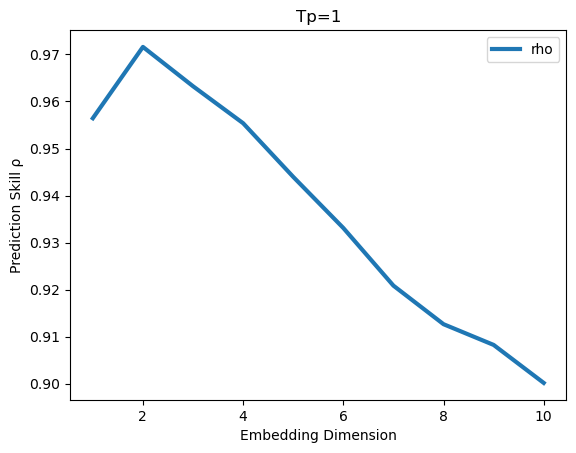

2


In [10]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [11]:
maxN = L - (E+1)
df = df[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_enso_lag1 = CCM(dataFrame=df,
                    E = int(E),
                    seed=30,
                    tau=-1,
                    columns='swe_level2',
                    target='ANOM',
                    libSizes=[15,maxN-1,8],
                    sample=100,)
                    # showPlot=True, returnObject=True)

In [12]:
ccm_enso_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [13]:
ccm_enso_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,)
               # showPlot=True, returnObject=True)

In [14]:
df = CCMsetup(-1, pdo)

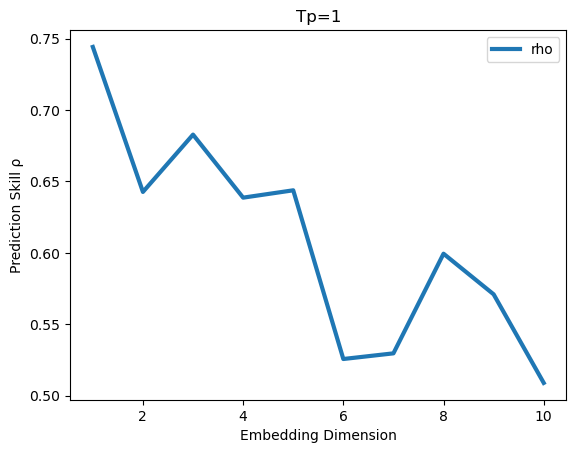

1


In [15]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [16]:
maxN = L - (E+1)

df = df[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_pdo_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [17]:
ccm_pdo_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [18]:
ccm_pdo_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [19]:
df = CCMsetup(-1, sst)

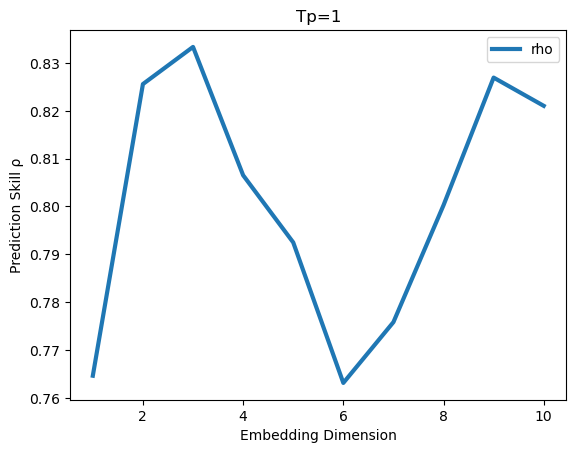

3


In [20]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [21]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_sst_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,)
               # showPlot=True, returnObject=True)

In [22]:
ccm_sst_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [23]:
ccm_sst_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

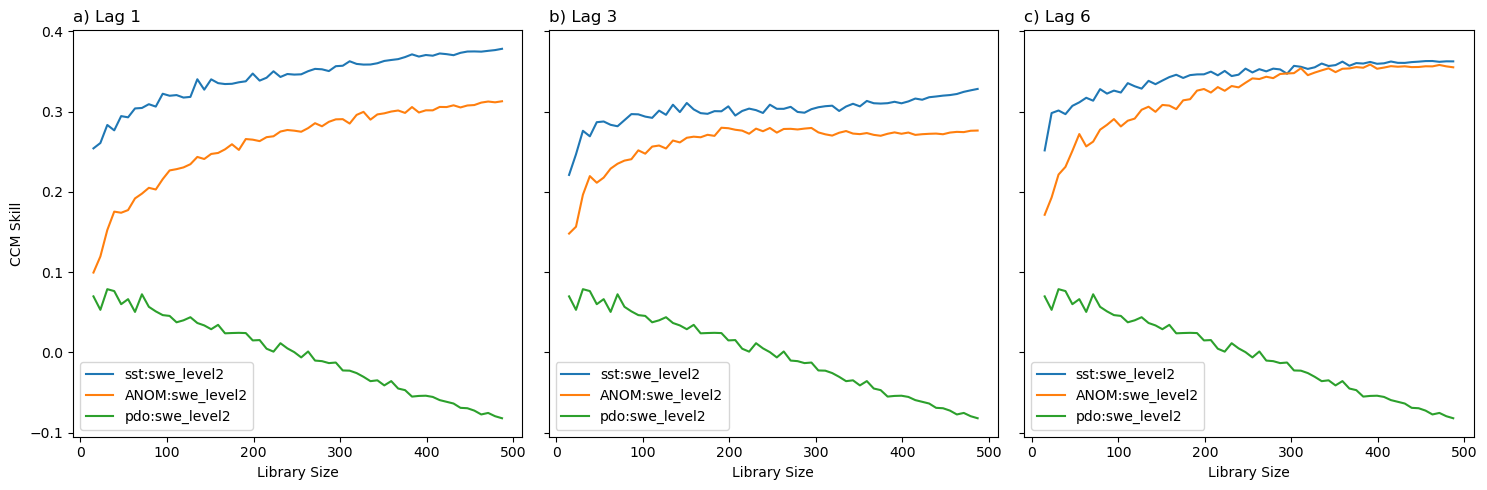

In [24]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1,3)

ax3 = fig.add_subplot(gs[2])
ax1 = fig.add_subplot(gs[0], sharey=ax3)
ax2 = fig.add_subplot(gs[1], sharey=ax3)

ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

ax1.set_xlabel('Library Size')
ax2.set_xlabel('Library Size')
ax3.set_xlabel('Library Size')

ax1.set_ylabel('CCM Skill')

ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
plt.tight_layout()

---
---

In [25]:
df_enso = CCMsetup(8, nino34)
df_pdo = CCMsetup(8, pdo)
df_sst = CCMsetup(8, sst)

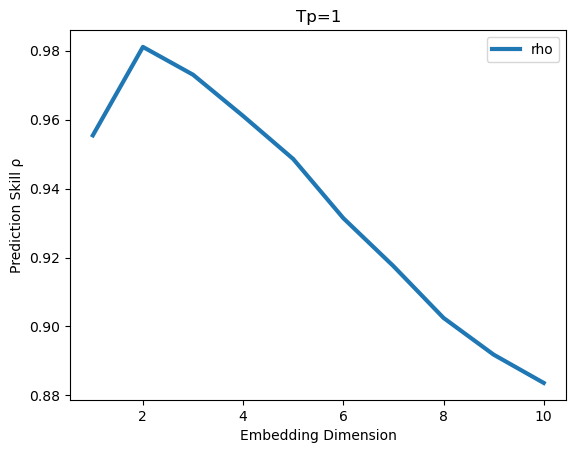

2


In [26]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [27]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,)
               # showPlot=True, returnObject=True)

In [28]:
ccm_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [29]:
ccm_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,)
               # showPlot=True, returnObject=True)

---

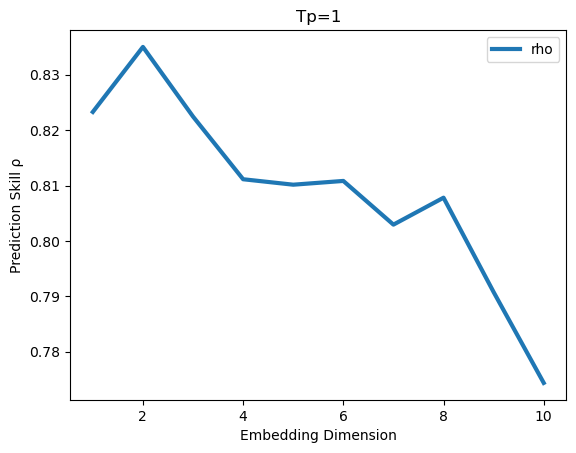

2


In [30]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [32]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [33]:
ccm_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [34]:
ccm_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

---

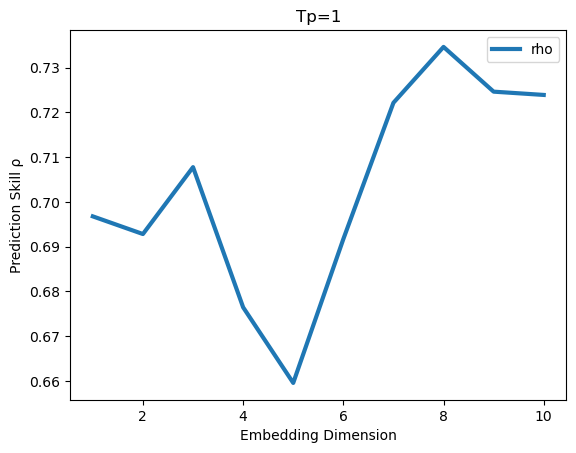

8


In [35]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [36]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [37]:
# look at orange line!
ccm_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

In [38]:
# look at orange line!
ccm_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,) 
               # showPlot=True, returnObject=True)

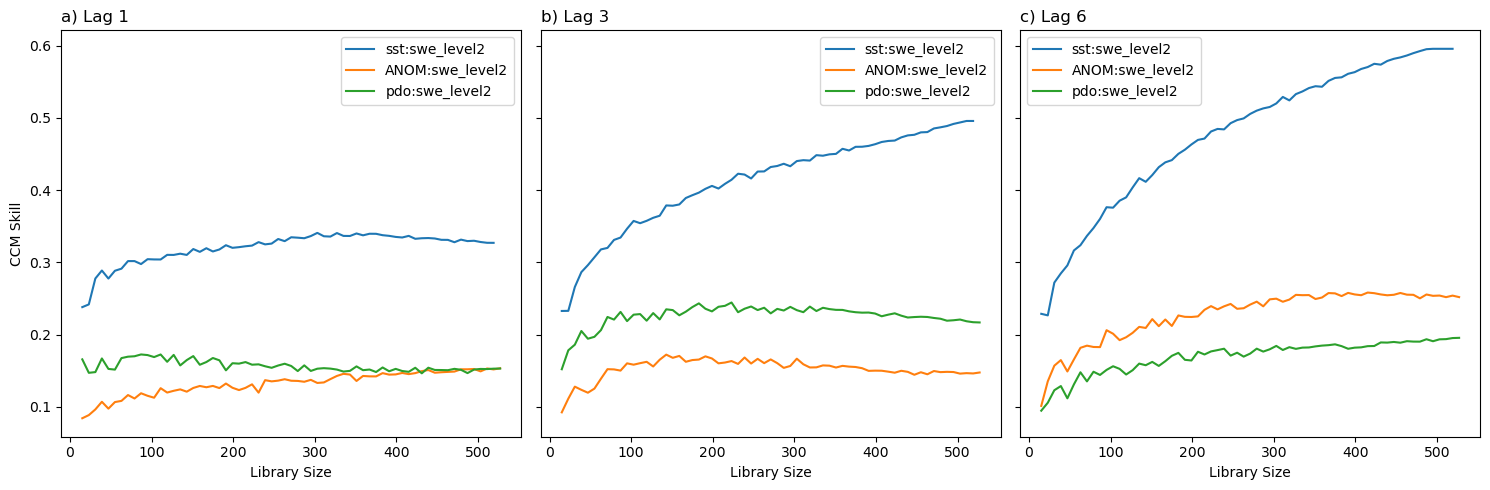

In [39]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1,3)

ax3 = fig.add_subplot(gs[2])
ax1 = fig.add_subplot(gs[0], sharey=ax3)
ax2 = fig.add_subplot(gs[1], sharey=ax3)

ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

ax1.set_xlabel('Library Size')
ax2.set_xlabel('Library Size')
ax3.set_xlabel('Library Size')

ax1.set_ylabel('CCM Skill')

ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
plt.tight_layout()

---
---

In [69]:
df_enso = CCMsetup(10, nino34)
df_pdo = CCMsetup(10, pdo)
df_sst = CCMsetup(10, sst)

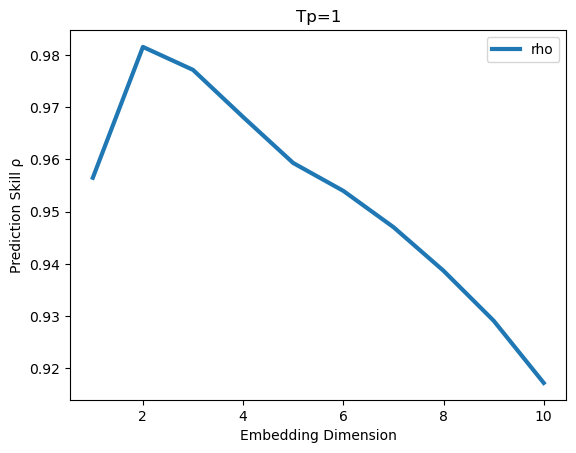

2


In [70]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [71]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

In [72]:
ccm_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [73]:
ccm_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

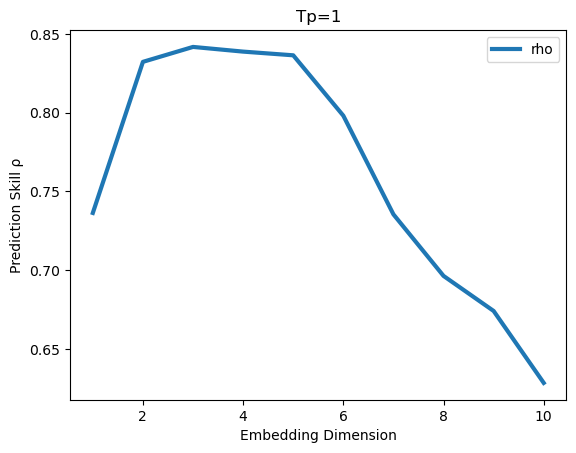

3


In [74]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [75]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [76]:
ccm_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [77]:
ccm_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

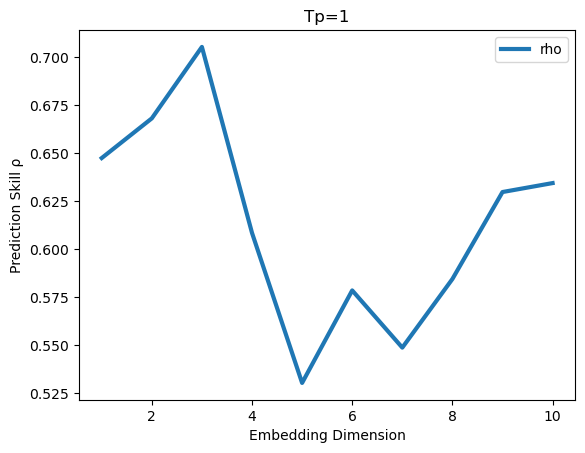

3


In [78]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [79]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [80]:
# look at orange line!
ccm_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [81]:
# look at orange line!
ccm_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

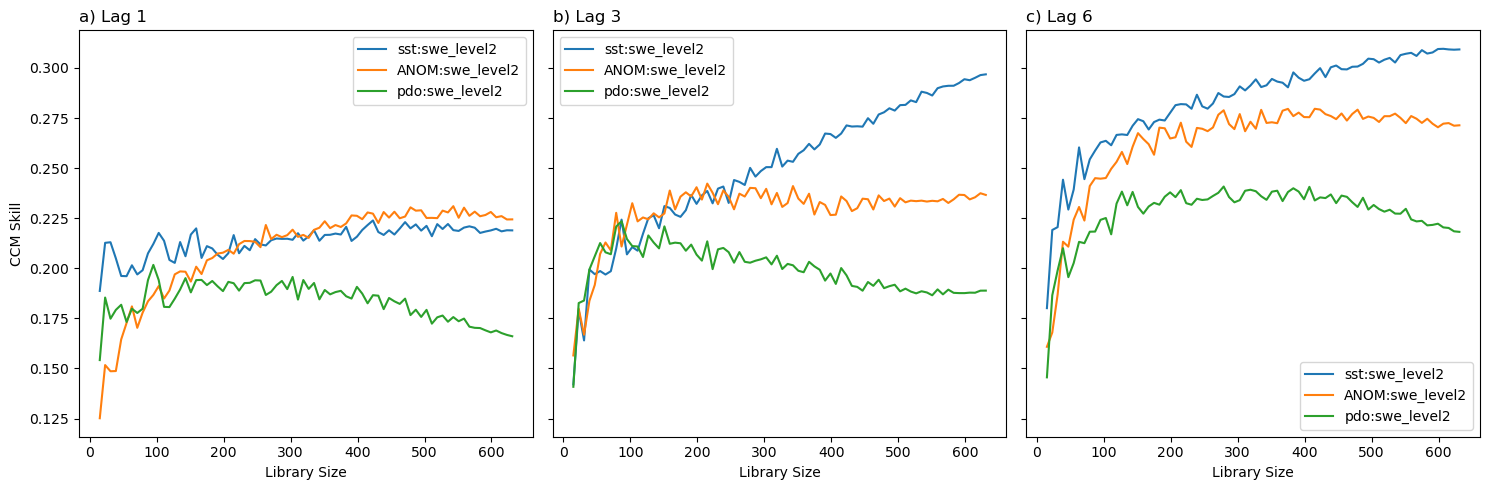

In [82]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1,3)

ax3 = fig.add_subplot(gs[2])
ax1 = fig.add_subplot(gs[0], sharey=ax3)
ax2 = fig.add_subplot(gs[1], sharey=ax3)

ccm_sst_lag1.libMeans.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
ccm_enso_lag1.libMeans.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag1.libMeans.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


ccm_sst_lag3.libMeans.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
ccm_enso_lag3.libMeans.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag3.libMeans.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


ccm_sst_lag6.libMeans.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
ccm_enso_lag6.libMeans.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
ccm_pdo_lag6.libMeans.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

ax1.set_xlabel('Library Size')
ax2.set_xlabel('Library Size')
ax3.set_xlabel('Library Size')

ax1.set_ylabel('CCM Skill')

ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
plt.tight_layout()